In [1]:
# step 1 
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
import time
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental import preprocessing
tf.__version__

2021-09-02 09:39:08.234909: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


'2.5.0'

In [42]:
# step 2 load data
weather = pd.read_csv('donetsk_17_21_with_storms.csv', sep=';', header=0, parse_dates=True, squeeze=True)
# weather.head()

In [43]:
weather['wind_direction'] = weather['wind_direction']*10
wv = weather.pop('wind_speed')

# Convert to radians.
wd_rad = weather.pop('wind_direction')*np.pi / 180

# Calculate the wind x and y components.
weather['w_x'] = wv*np.cos(wd_rad)
weather['w_y'] = wv*np.sin(wd_rad)

In [44]:
date_time = pd.to_datetime(weather.pop('started_at'), format='%Y-%m-%d %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [45]:
day = 24*60*60
year = (365.2425)*day

weather['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
weather['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
weather['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
weather['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [46]:
weather.head()

,cloud_height,cloud_amount,temperature,temperature_dew,pressure,pressure_tendency,pressure_tendency_value,code,w_x,w_y,day_sin,day_cos,year_sin,year_cos
0,5,8,14.4,13.5,989.4,7,1.3,0,0.000000,0.000000,-2.942611e-12,1.000000e+00,-0.866949,-0.498398
1,5,8,14.2,13.4,989.3,7,0.1,0,0.000000,0.000000,7.071068e-01,7.071068e-01,-0.868018,-0.496532
2,5,8,15.2,13.2,989.7,3,0.4,0,0.000000,0.000000,1.000000e+00,5.505955e-12,-0.869084,-0.494665
3,5,6,17.7,13.2,988.9,8,0.8,8,-0.684040,-1.879385,7.071068e-01,-7.071068e-01,-0.870146,-0.492795
4,5,7,16.5,13.4,989.1,3,0.2,8,-1.368081,-3.758770,8.069299e-12,-1.000000e+00,-0.871203,-0.490922


In [47]:
# step 3 training - validation split
val_weather = weather.sample(frac=0.2, random_state=1337)
train_weather = weather.drop(val_weather.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_weather), len(val_weather))
)

Using 9088 samples for training and 2272 for validation


In [48]:
# step 4 transform to dataset
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("code")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_weather)
val_ds = dataframe_to_dataset(val_weather)

In [49]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'cloud_height': <tf.Tensor: shape=(), dtype=int64, numpy=10>, 'cloud_amount': <tf.Tensor: shape=(), dtype=int64, numpy=9>, 'temperature': <tf.Tensor: shape=(), dtype=float64, numpy=0.3>, 'temperature_dew': <tf.Tensor: shape=(), dtype=float64, numpy=0.3>, 'pressure': <tf.Tensor: shape=(), dtype=float64, numpy=976.5>, 'pressure_tendency': <tf.Tensor: shape=(), dtype=int64, numpy=8>, 'pressure_tendency_value': <tf.Tensor: shape=(), dtype=float64, numpy=0.8>, 'w_x': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'w_y': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'day_sin': <tf.Tensor: shape=(), dtype=float64, numpy=-1.0>, 'day_cos': <tf.Tensor: shape=(), dtype=float64, numpy=-1.0748247302817818e-11>, 'year_sin': <tf.Tensor: shape=(), dtype=float64, numpy=0.2529829736045368>, 'year_cos': <tf.Tensor: shape=(), dtype=float64, numpy=0.9674707308576349>}
Target: tf.Tensor(0, shape=(), dtype=int64)


In [50]:
# step 5 to batch
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [51]:
import tensorflow
# from tensorflow.keras.layers import CategoryEncoding
def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = preprocessing.Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature

def encode_integer_categorical_feature(feature, name, dataset):
    # Create a CategoryEncoding for our integer indices
#     encoder = sklearn.preprocessing.CategoryEncoding(output_mode="binary")
#     encoder = tensorflow.keras.layers.experimental.preprocessing.CategoryEncoding(output_mode="binary")
    encoder = tf.keras.layers.experimental.preprocessing.CategoryEncoding(num_tokens=11, output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the space of possible indices
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices
    encoded_feature = encoder(feature)
    return encoded_feature
# weather.head()

In [54]:
# step 7 prepare data and model

cloud_height = keras.Input(shape=(1,), name="cloud_height", dtype="int64")
cloud_amount = keras.Input(shape=(1,), name="cloud_amount", dtype="int64")
pressure_tendency = keras.Input(shape=(1,), name="pressure_tendency", dtype="int64")

# Numerical features
# w_s = keras.Input(shape=(1,), name="w_s")
temperature = keras.Input(shape=(1,), name="temperature")
temperature_dew = keras.Input(shape=(1,), name="temperature_dew")
pressure = keras.Input(shape=(1,), name="pressure")
pressure_tendency_value = keras.Input(shape=(1,), name="pressure_tendency_value")
w_x = keras.Input(shape=(1,), name="w_x")
w_y = keras.Input(shape=(1,), name="w_y")
day_sin = keras.Input(shape=(1,), name="day_sin")
day_cos = keras.Input(shape=(1,), name="day_cos")
year_sin = keras.Input(shape=(1,), name="year_sin")
year_cos = keras.Input(shape=(1,), name="year_cos")

all_inputs = [
    cloud_height,
    cloud_amount,
    pressure_tendency,
    temperature,
    temperature_dew,
    pressure,
    pressure_tendency_value,
    w_x,
    w_y,
    day_sin,
    day_cos,
    year_sin,
    year_cos,
]

# Integer categorical features
cloud_height_encoded = encode_integer_categorical_feature(cloud_height, "cloud_height", train_ds)
cloud_amount_encoded = encode_integer_categorical_feature(cloud_amount, "cloud_amount", train_ds)
pressure_tendency_encoded = encode_integer_categorical_feature(pressure_tendency, "pressure_tendency", train_ds)

# String categorical features
# thal_encoded = encode_string_categorical_feature(thal, "thal", train_ds)

# Numerical features
temperature_encoded = encode_numerical_feature(temperature, "temperature", train_ds)
temperature_dew_encoded = encode_numerical_feature(temperature_dew, "temperature_dew", train_ds)
pressure_encoded = encode_numerical_feature(pressure, "pressure", train_ds)
pressure_tendency_value_encoded = encode_numerical_feature(pressure_tendency_value, "pressure_tendency_value", train_ds)
w_x_encoded = encode_numerical_feature(w_x, 'w_x', train_ds)
w_y_encoded = encode_numerical_feature(w_y, 'w_y', train_ds)
day_sin_encoded = encode_numerical_feature(day_sin, 'day_sin', train_ds)
day_cos_encoded = encode_numerical_feature(day_cos, 'day_cos', train_ds)
year_sin_encoded = encode_numerical_feature(year_sin, 'year_sin', train_ds)
year_cos_encoded = encode_numerical_feature(year_cos, 'year_cos', train_ds)

all_features = layers.concatenate(
    [
        cloud_height_encoded,
        cloud_amount_encoded,
        pressure_tendency_encoded,
        temperature_encoded,
        temperature_dew_encoded,
        pressure_encoded,
        w_x_encoded,
        w_y_encoded,
        day_sin_encoded,
        day_cos_encoded,
        year_sin_encoded,
        year_cos_encoded
    ]
)
x = layers.Dense(256, activation="relu")(all_features)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation="relu")(x)
# x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.1)(x)
# x = layers.Dropout(0.5)(x)
# x = layers.Dense(256, activation="relu")(x),
# x = layers.Dropout(0.3)(x),
output = layers.Dense(9, activation="softmax")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

In [55]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cloud_height (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
cloud_amount (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
pressure_tendency (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
temperature (InputLayer)        [(None, 1)]          0                                            
____________________________________________________________________________________________

In [56]:
# step 8 fit model
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
284/284 [==============================] - 4s 8ms/step - loss: 0.4872 - accuracy: 0.8792 - val_loss: 0.4847 - val_accuracy: 0.8939
Epoch 2/50
284/284 [==============================] - 2s 7ms/step - loss: 0.3685 - accuracy: 0.8990 - val_loss: 0.3923 - val_accuracy: 0.9005
Epoch 3/50
284/284 [==============================] - 2s 6ms/step - loss: 0.3409 - accuracy: 0.8994 - val_loss: 0.3656 - val_accuracy: 0.9036
Epoch 4/50
284/284 [==============================] - 2s 6ms/step - loss: 0.3212 - accuracy: 0.9014 - val_loss: 0.3622 - val_accuracy: 0.8996
Epoch 5/50
284/284 [==============================] - 2s 8ms/step - loss: 0.3063 - accuracy: 0.9043 - val_loss: 0.3680 - val_accuracy: 0.8917
Epoch 6/50
284/284 [==============================] - 2s 6ms/step - loss: 0.2977 - accuracy: 0.9055 - val_loss: 0.3656 - val_accuracy: 0.9036
Epoch 7/50
284/284 [==============================] - 2s 6ms/step - loss: 0.2843 - accuracy: 0.9066 - val_loss: 0.3749 - val_accuracy: 0.8970
Epoch 

In [15]:
model.save('multistorm_donetsk_model')
# test_results = {}
# test_results['dnn_model'] = model.evaluate(test_ds, test_labels, verbose=0)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: multistorm_donetsk_model/assets


In [57]:
def prepare_data(date_term, telegram, model_name):
    ret = {}
    ret['cloud_height'] = int(telegram[14:15])
    ret['cloud_amount'] = int(telegram[18:19])
    ret['pressure_tendency'] = int(telegram[49:50])
    sign = ''
    if telegram[25:26] == '1':
        sign = '-'
    ret['temperature'] = float(sign+telegram[26:28]+'.'+telegram[28:29])
    sign = ''
    if telegram[31:32] == '1':
        sign = '-'
    ret['temperature_dew'] = float(sign+telegram[32:34]+'.'+telegram[34:35])
    p1 = '1'
    if telegram[37:38] != '0':
        p1 = ''
    ret['pressure'] = float(p1+telegram[37:40]+'.'+telegram[40:41])
    ret['pressure_tendency_value'] = float(telegram[50:52]+'.'+telegram[52:53])
    wv = float(telegram[21:23]+'.')
    wd_rad = int(telegram[19:21])*10*np.pi/180
    ret['w_x'] = wv*np.cos(wd_rad)
    ret['w_y'] = wv*np.sin(wd_rad)
    d = datetime.strptime(date_term, "%Y-%m-%d %H:%M:%S")
    s = time.mktime(d.timetuple())
    day = 24*60*60
    year = (365.2425)*day
    ret['day_sin'] = np.sin(s * (2 * np.pi / day))
    ret['day_cos'] = np.cos(s * (2 * np.pi / day))
    ret['year_sin'] = np.sin(s * (2 * np.pi / year))
    ret['year_cos'] = np.cos(s * (2 * np.pi / year))
    input_dict = {name: tf.convert_to_tensor([value]) for name, value in ret.items()}
#     model = tf.keras.models.load_model(model_name)
    predictions = model.predict(input_dict)
    
    return predictions

d_t = '2021-09-02 06:00:00'
telegram = 'ЩЭСМЮ 34519 11697 72304 10190 20149 39800 40032 57013 69962 72511 87900 333 20164 555 11022='
predictions = prepare_data(d_t, telegram, 'multistorm_donetsk_model')
# predictions

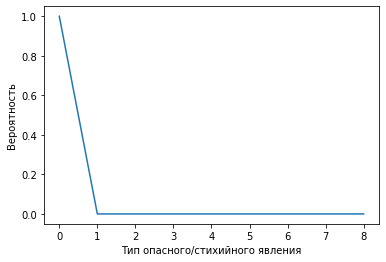

In [58]:
plt.plot(np.squeeze(predictions))
plt.ylabel('Вероятность')
plt.xlabel('Тип опасного/стихийного явления')
# plt.title("Learning rate =" + str(learning_rate))
plt.show()

<BarContainer object of 9 artists>

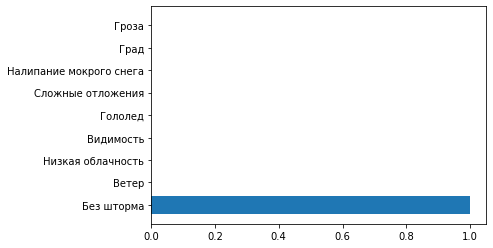

In [59]:
storm = ('Без шторма', 'Ветер', 'Низкая облачность', 'Видимость', 'Гололед', 'Сложные отложения', 'Налипание мокрого снега', 'Град', 'Гроза')
fig, ax = plt.subplots()
ax.barh(storm, np.squeeze(predictions))

In [17]:
predictions

array([[6.5542434e-28, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00]], dtype=float32)

In [19]:
print("Max Value of Action ->  {}".format(-3e-3))

Max Value of Action ->  -0.003
